## Set up

In [1]:
%%capture
!pip install tensorflow
!pip install gdown
!pip install transformers

In [2]:
import numpy as np
import pandas as pd
import os

import torch
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
import random

import gdown

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics.cluster import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

In [16]:
def set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).

    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if is_torch_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
    if is_tf_available():
        import tensorflow as tf

        tf.random.set_seed(seed)
SEED = 42
set_seed(SEED)

## Data

In [4]:
REMOTE_MODEL_FOLDER = 'https://drive.google.com/drive/folders/1v_eKiOtzGZoqz3o1HpN9c26UdKQ8lECM?usp=sharing'
LOCAL_MODEL_FOLDER = 'Codalab_Online_Orders'

In [5]:
gdown.download_folder(url=REMOTE_MODEL_FOLDER, output=LOCAL_MODEL_FOLDER, quiet=True)

['Codalab_Online_Orders/input_data.csv',
 'Codalab_Online_Orders/public_data.csv']

In [6]:
training_data_path = os.path.join(LOCAL_MODEL_FOLDER, 'public_data.csv')
testing_data_path = os.path.join(LOCAL_MODEL_FOLDER, 'input_data.csv')

In [7]:
train_df = pd.read_csv(training_data_path)
print(train_df.info())
print(train_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11623 entries, 0 to 11622
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       11623 non-null  int64 
 1   message  11623 non-null  object
 2   label    11623 non-null  object
dtypes: int64(1), object(2)
memory usage: 272.5+ KB
None
      id                                            message  \
0   8793    hi i want change my address from my credit card   
1   3083  i need 4 fruit maple oatmeal 3 cold brew froze...   
2   5932        i wish to travel next month domestic airway   
3  12077                   i need reimbursement my expenses   
4   6608              i need a copy of insurance for my car   

                 label  
0        updateaddress  
1     orderdrinkintent  
2           bookflight  
3        expensereport  
4  getproofofinsurance  


## Text & Label EDA

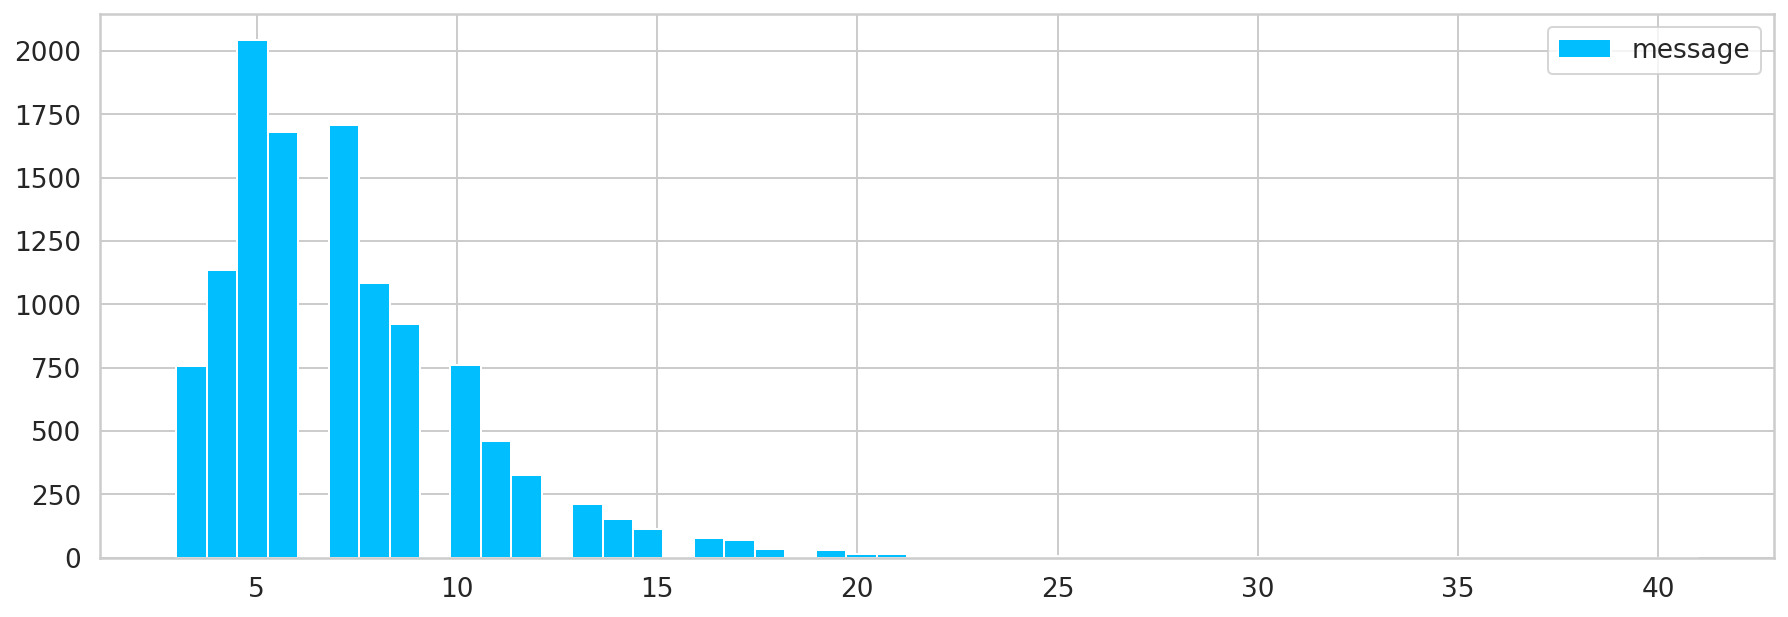

In [8]:
train_df['message'].str.split().map(lambda x: len(x)).hist(bins=50, figsize=(15,5), legend=True);

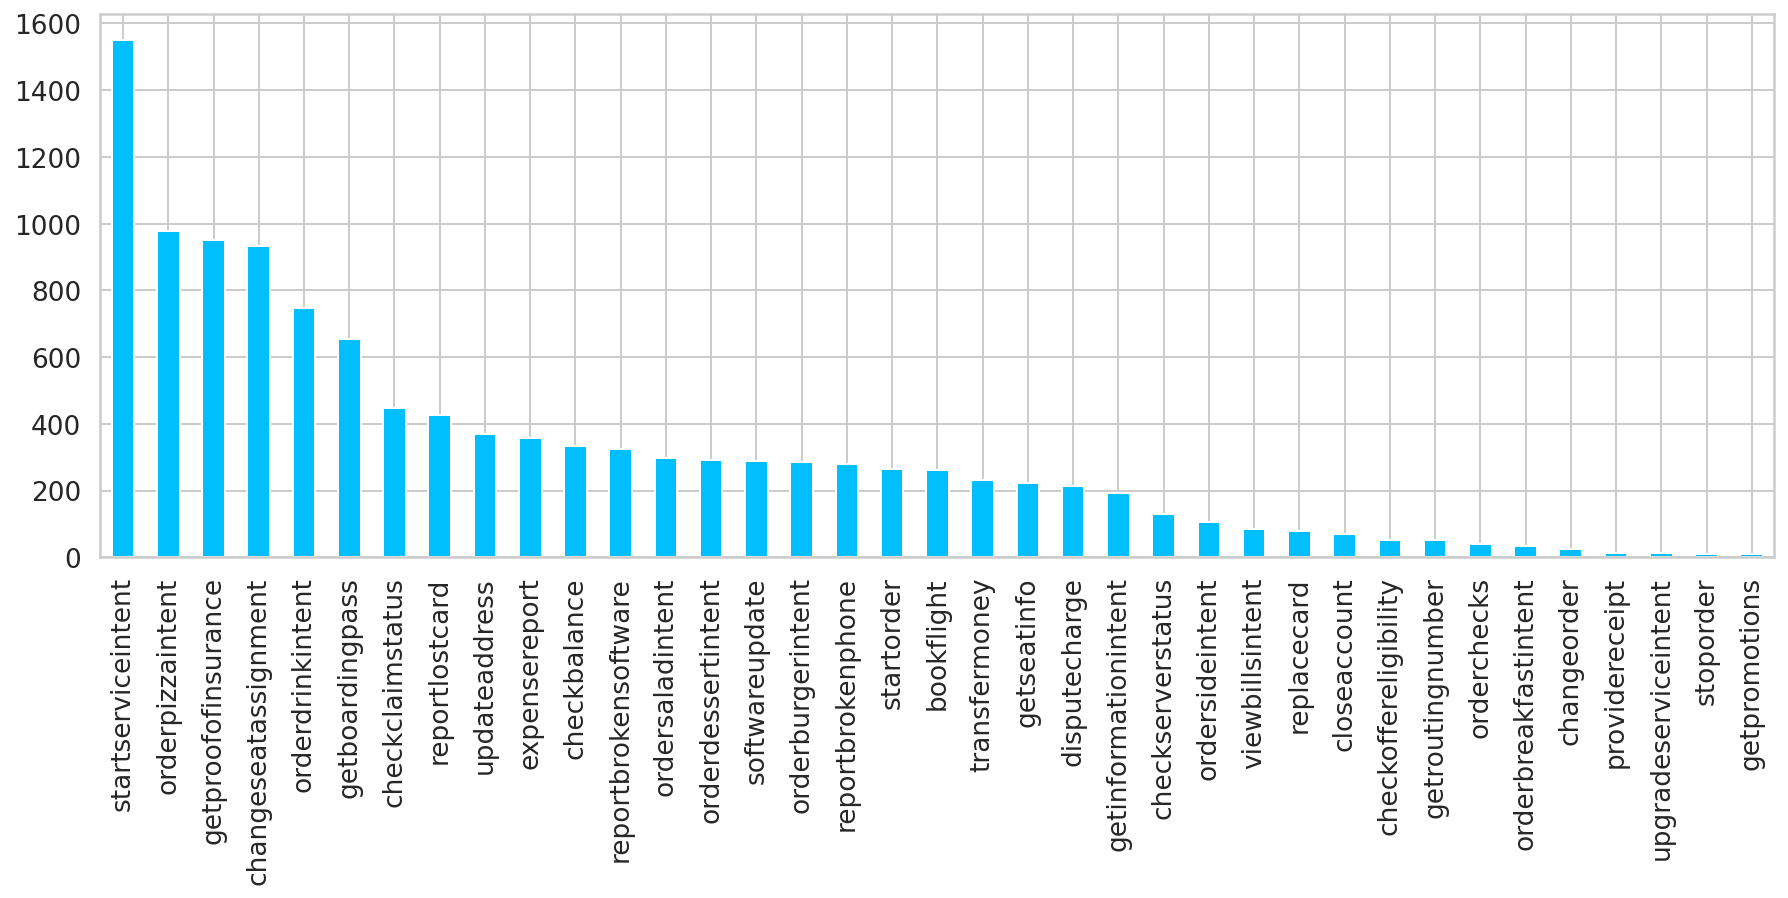

In [9]:
train_df.label.value_counts().plot(kind='bar', figsize=(15,5));

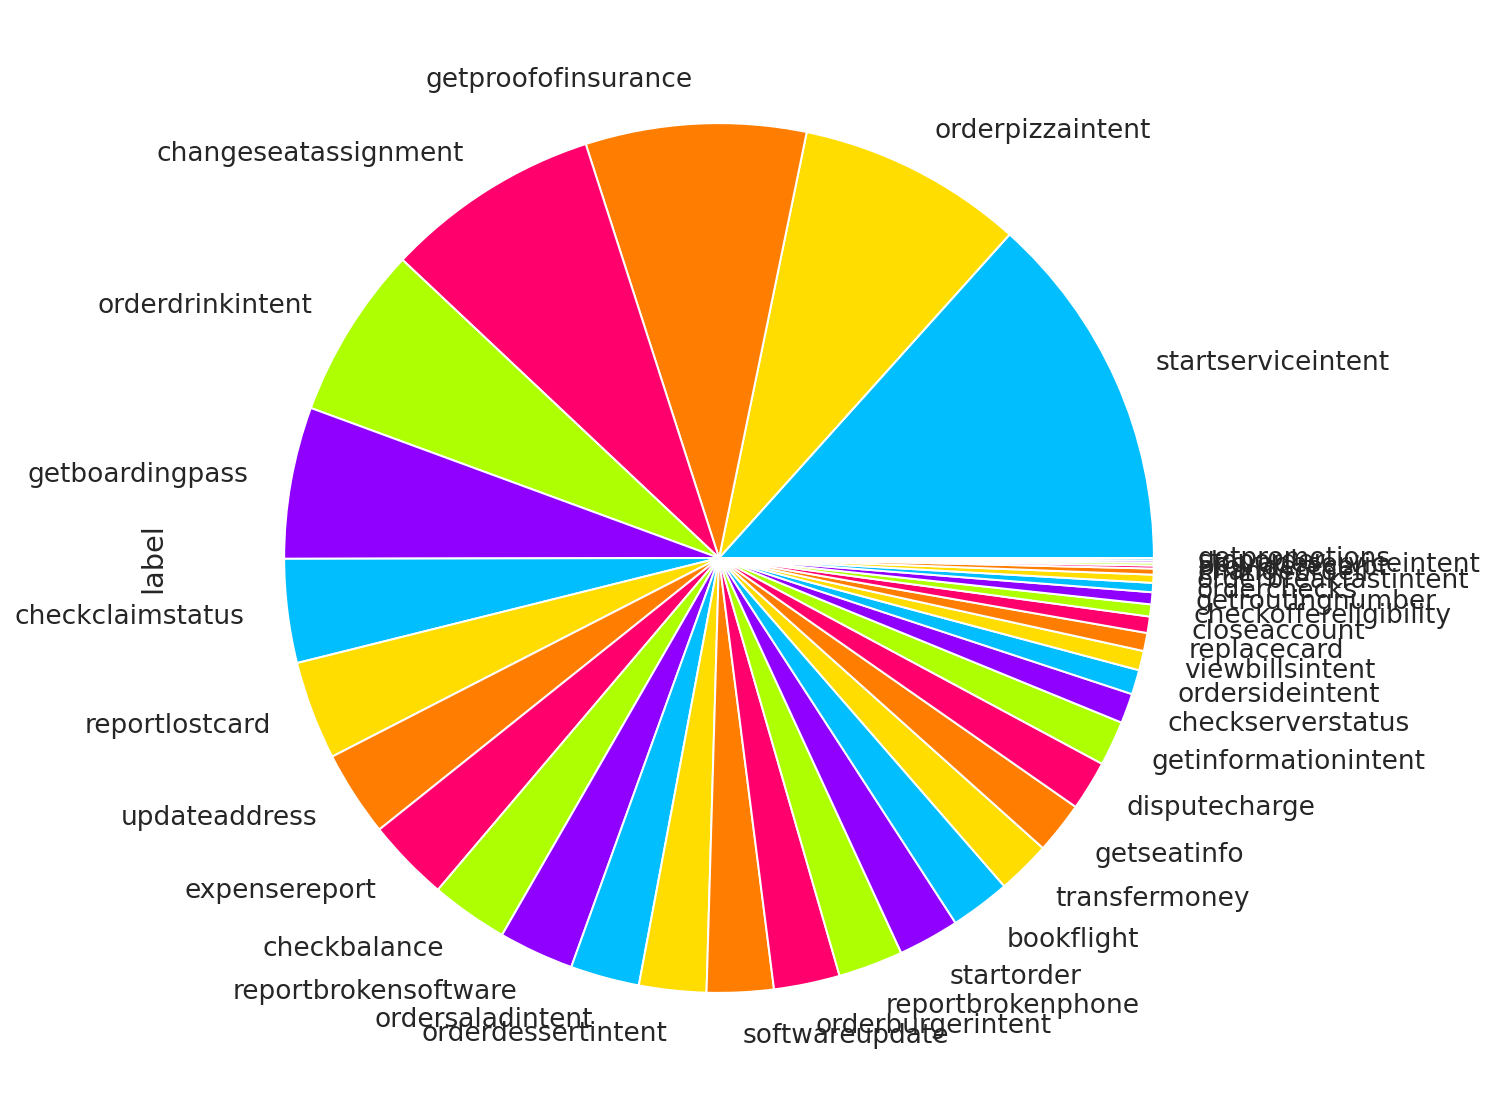

In [10]:
train_df.label.value_counts().plot(kind='pie', figsize=(30,10));

## Data Cleaning/Preprocessing

In [11]:
X = train_df['message']
y = train_df['label']

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(9298,)
(9298,)
(2325,)
(2325,)


## Text Vectorization

In [14]:
# build a vocabulary that only consider the top max_features ordered by term frequency across the corpus.
max_features = 500

In [15]:
vectorizer = TfidfVectorizer(
    token_pattern = '[a-zA-Z0-9@#]+',
    strip_accents = 'unicode',
    lowercase = True,
    stop_words = 'english',
    ngram_range = {1,3},
    max_df = 0.70,
    min_df = 0.001,
    max_features = max_features
)

## Model Building

In [17]:
pipe = Pipeline([('vec', vectorizer),  ('clf', DecisionTreeClassifier(random_state=SEED))])

## Hyperparameters Tuning

In [18]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('vec',
                 TfidfVectorizer(max_df=0.7, max_features=500, min_df=0.001,
                                 ngram_range={1, 3}, stop_words='english',
                                 strip_accents='unicode',
                                 token_pattern='[a-zA-Z0-9@#]+')),
                ('clf', DecisionTreeClassifier(random_state=42))])

In [19]:
pred_val = pipe.predict(X_val)
cm = confusion_matrix(y_val, pred_val)
clf_report = classification_report(y_val, pred_val)
print(cm)
print(clf_report)

[[ 41   0   0 ...   0   0   0]
 [  0   4   0 ...   0   0   0]
 [  0   0 176 ...   0   0   2]
 ...
 [  0   0   0 ...  69   0   0]
 [  0   0   1 ...   0   1   0]
 [  0   0   0 ...   0   0  12]]
                       precision    recall  f1-score   support

           bookflight       0.91      0.98      0.94        42
          changeorder       0.57      0.80      0.67         5
 changeseatassignment       0.87      0.92      0.89       192
         checkbalance       0.89      0.98      0.93        50
     checkclaimstatus       0.97      0.99      0.98        90
checkoffereligibility       1.00      1.00      1.00         6
    checkserverstatus       0.97      0.97      0.97        30
         closeaccount       0.86      0.95      0.90        20
        disputecharge       0.91      0.74      0.82        42
        expensereport       0.96      0.96      0.96        77
      getboardingpass       1.00      0.99      1.00       114
 getinformationintent       0.90      0.84      0.8

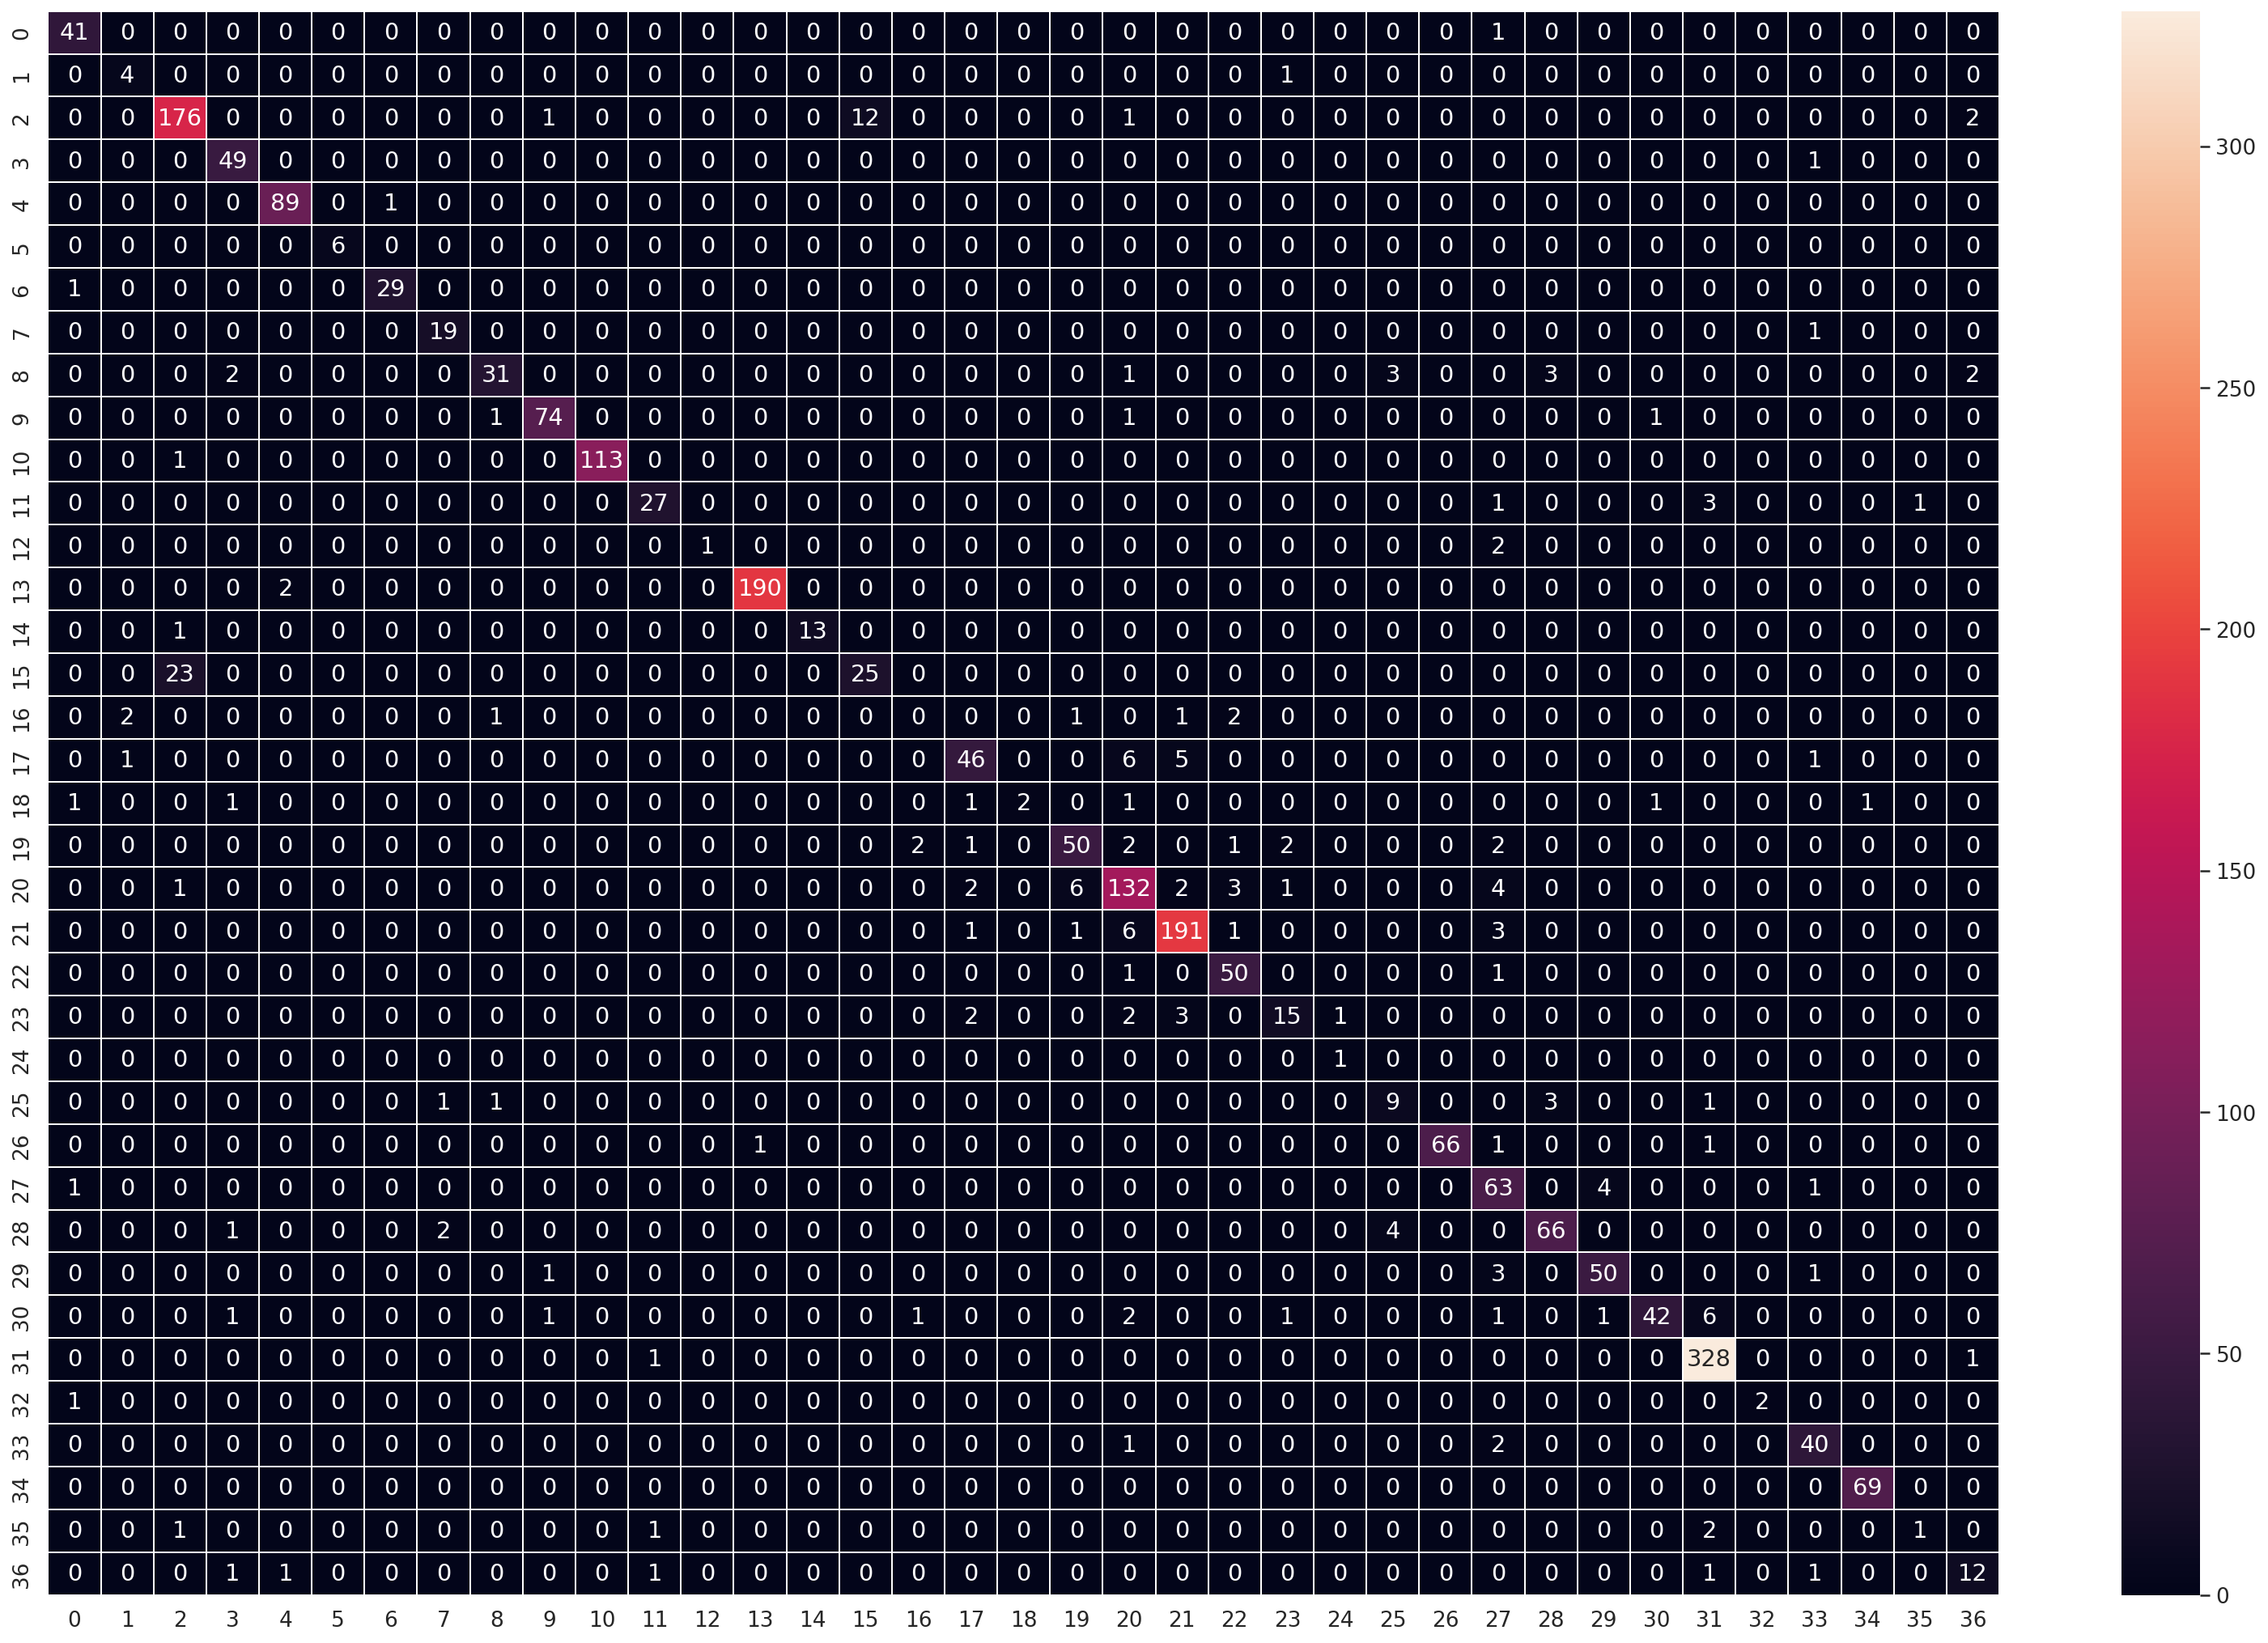

In [20]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(27, 18))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, ax=ax);

In [21]:
ari = adjusted_rand_score(y_val, pred_val)
ami = adjusted_mutual_info_score(y_val, pred_val, average_method='arithmetic')

print("ARI: {}".format(ari))
print("AMI: {}".format(ami))

ARI: 0.8859327262366226
AMI: 0.8817270970543543


## Predictions

In [22]:
df_test = pd.read_csv(testing_data_path)
df_test.info()
df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2906 entries, 0 to 2905
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       2906 non-null   int64 
 1   message  2906 non-null   object
dtypes: int64(1), object(1)
memory usage: 45.5+ KB


,id,message
0,12123,i have problem in excel
1,244,i need \t pesto drizzle over grilled chicken c...
2,8221,need to help order a new card as the old one e...
3,12856,i need internet plan
4,12108,my are report travel


In [23]:
pred_test = pipe.predict(df_test['message'])

## Model Submission

In [24]:
my_submission = pd.DataFrame({'Id': df_test['id'], 'label': pred_test})
print(my_submission.head())

      Id                 label
0  12123  reportbrokensoftware
1    244      orderpizzaintent
2   8221           replacecard
3  12856    startserviceintent
4  12108         expensereport


In [25]:
# NOTE: after saving the CSV file, be sure to zip the file before submitting to the competition website!
my_submission.to_csv('answers.csv', index=False)